In [1]:
import ast
import datetime
from elasticsearch import Elasticsearch
import hashlib
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pytrec_eval
from tqdm import tqdm

current_timestamp = datetime.datetime.now()



# Data Exploration

## `train.csv` and  `test.csv`

In [2]:
df_train = pd.read_csv('raw_data/train.csv', encoding = 'ISO-8859-1')
df_train['filename'] = 'train.csv'

df_test = pd.read_csv('raw_data/test.csv', encoding = 'ISO-8859-1')
df_test['filename'] = 'test.csv'

print(f'training shape: {str(df_train.shape)}')
print(f'test shape: {str(df_test.shape)}')

df = pd.concat([df_train, df_test]).reset_index(drop=True)
print(f'df.head():')
df.head()

training shape: (74067, 6)
test shape: (166693, 5)
df.head():


,id,product_uid,product_title,search_term,relevance,filename
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,train.csv
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,train.csv
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,train.csv
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,train.csv
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,train.csv


In [3]:
# How many unique search terms are there?

total_unique_terms = len(df['search_term'].unique())
print("Total Number of Unique Search Terms:", total_unique_terms)

train_df = df[df['filename'] == 'train.csv']
unique_terms_train = len(train_df['search_term'].unique())
print("Unique Search Terms in 'train.csv':", unique_terms_train)

test_df = df[df['filename'] == 'test.csv']
unique_terms_test = len(test_df['search_term'].unique())
print("Unique Search Terms in 'test.csv':", unique_terms_test)

train_terms = set(train_df['search_term'].unique())
test_terms = set(test_df['search_term'].unique())

shared_terms = train_terms.intersection(test_terms)
unique_terms_both = len(shared_terms)

print("Unique Search Terms in Both:", unique_terms_both) 





Total Number of Unique Search Terms: 24601
Unique Search Terms in 'train.csv': 11795
Unique Search Terms in 'test.csv': 22427
Unique Search Terms in Both: 9621


In [4]:
# How many results do we get per search term?

df.groupby('search_term').size().value_counts().sort_index()

1     2286
2     1671
3     1314
4     1020
5      940
6      908
7     1001
8     1181
9     1344
10    1438
11    1447
12    1333
13    1166
14    1152
15    1309
16    1323
17    1305
18     981
19     650
20     350
21     115
22      33
23     333
36       1
Name: count, dtype: int64

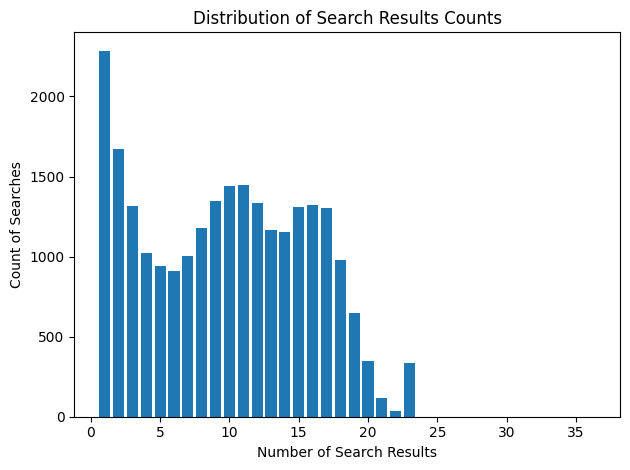

In [5]:
search_term_counts = df.groupby('search_term').size().value_counts().sort_index()

plt.figure()
plt.bar(search_term_counts.index, search_term_counts.values)
plt.xlabel('Number of Search Results')
plt.ylabel('Count of Searches')
plt.title('Distribution of Search Results Counts') 
plt.tight_layout()
plt.show()

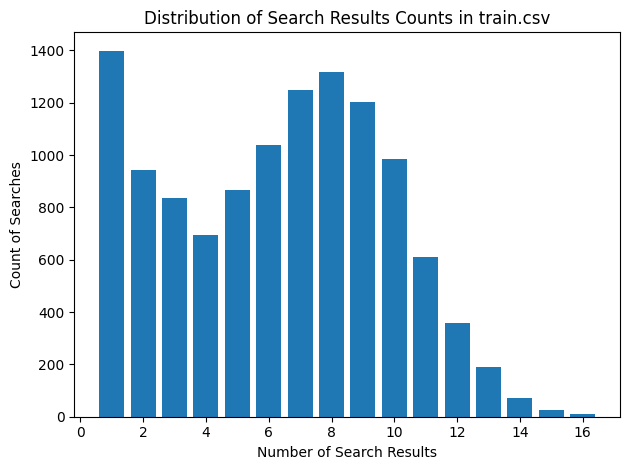

In [6]:
search_term_counts = df[df['filename']=='train.csv'].groupby('search_term').size().value_counts().sort_index()

plt.figure()
plt.bar(search_term_counts.index, search_term_counts.values)
plt.xlabel('Number of Search Results')
plt.ylabel('Count of Searches')
plt.title('Distribution of Search Results Counts in train.csv') 
plt.tight_layout()
plt.show()

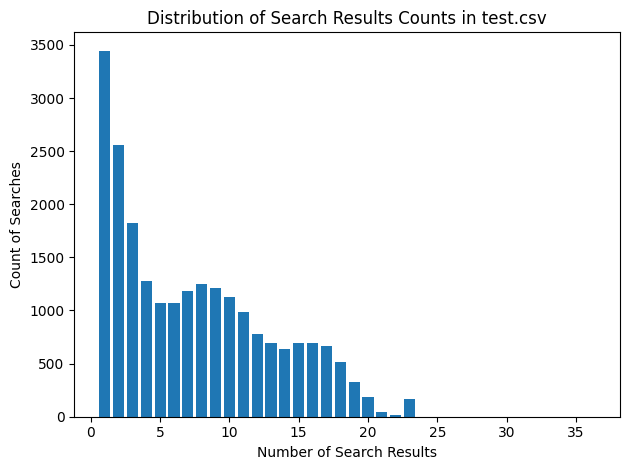

In [7]:
search_term_counts = df[df['filename']=='test.csv'].groupby('search_term').size().value_counts().sort_index()

plt.figure()
plt.bar(search_term_counts.index, search_term_counts.values)
plt.xlabel('Number of Search Results')
plt.ylabel('Count of Searches')
plt.title('Distribution of Search Results Counts in test.csv') 
plt.tight_layout()
plt.show()

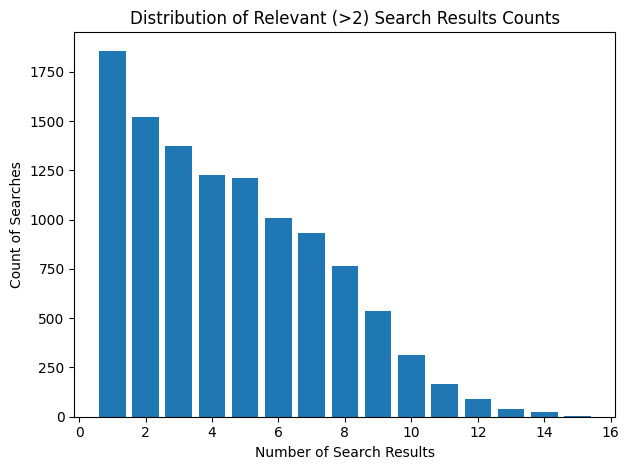

In [8]:
# What about relevant search results?
search_term_counts = df[df['relevance']>2].groupby('search_term').size().value_counts().sort_index()

plt.figure()
plt.bar(search_term_counts.index, search_term_counts.values)
plt.xlabel('Number of Search Results')
plt.ylabel('Count of Searches')
plt.title('Distribution of Relevant (>2) Search Results Counts') 
plt.tight_layout()
plt.show()

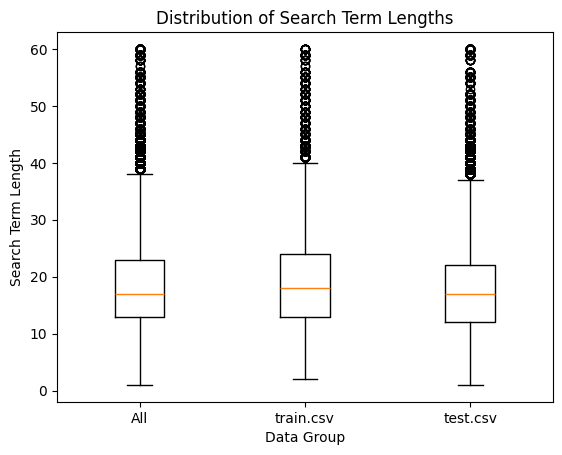

pd.describe() of all search lengths


count    240760.000000
mean         18.187897
std           7.733805
min           1.000000
25%          13.000000
50%          17.000000
75%          23.000000
max          60.000000
dtype: float64

In [9]:
# How long are the search terms?

search_lengths = [len(x) for x in df['search_term']]
search_lengths_train = [len(x) for x in df[df['filename']=='train.csv']['search_term']]
search_lengths_test = [len(x) for x in df[df['filename']=='test.csv']['search_term']]

# Create the boxplot
plt.figure()
plt.boxplot([search_lengths, search_lengths_train, search_lengths_test])
plt.xticks([1, 2, 3], ['All', 'train.csv', 'test.csv'])  # Set labels
plt.xlabel('Data Group')
plt.ylabel('Search Term Length')
plt.title('Distribution of Search Term Lengths')
plt.show()

print("pd.describe() of all search lengths")
pd.Series(search_lengths).describe()

In [10]:
# How many unique products are there?

total_unique_prods = len(df['product_uid'].unique())
print("Total Number of Unique Products:", total_unique_prods)

train_df = df[df['filename'] == 'train.csv']
unique_prods_train = len(train_df['product_uid'].unique())
print("Unique Products in 'train.csv':", unique_prods_train)

test_df = df[df['filename'] == 'test.csv']
unique_prods_test = len(test_df['product_uid'].unique())
print("Unique Products in 'test.csv':", unique_prods_test)

train_prods = set(train_df['product_uid'].unique())
test_prods = set(test_df['product_uid'].unique())

shared_prods = train_prods.intersection(test_prods)
unique_prods_both = len(shared_prods)

print("Unique Products in Both:", unique_prods_both) 

Total Number of Unique Products: 124428
Unique Products in 'train.csv': 54667
Unique Products in 'test.csv': 97460
Unique Products in Both: 27699


In [11]:
# What does the distribution of relevance scores look like?

df.groupby('relevance').size()

relevance
1.00     2105
1.25        4
1.33     3006
1.50        5
1.67     6780
1.75        9
2.00    11730
2.25       11
2.33    16060
2.50       19
2.67    15202
2.75       11
3.00    19125
dtype: int64

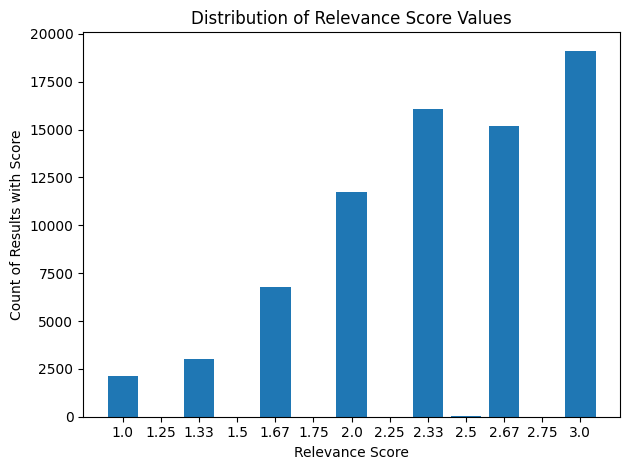

In [12]:
relevance_counts = df.groupby('relevance').size()

plt.figure()
plt.bar([str(x) for x in relevance_counts.index], relevance_counts.values)
plt.xlabel('Relevance Score')
plt.ylabel('Count of Results with Score')
plt.title('Distribution of Relevance Score Values') 
plt.tight_layout()
plt.show()

## `product_descriptions.csv`

In [15]:
df_desc = pd.read_csv('raw_data/product_descriptions.csv', encoding = 'ISO-8859-1')
print(df_desc.shape)
df_desc.head()

(124428, 2)


,product_uid,product_description
0,100001,"Not only do angles make joints stronger, they ..."
1,100002,BEHR Premium Textured DECKOVER is an innovativ...
2,100003,Classic architecture meets contemporary design...
3,100004,The Grape Solar 265-Watt Polycrystalline PV So...
4,100005,Update your bathroom with the Delta Vero Singl...


In [16]:
# How many products are there, is it one row per?

len(df_desc['product_uid'].unique())

124428

In [17]:
# Do all products in the test and train sets have descriptions?

df_product_uids = set(df['product_uid'])
df_desc_product_uids = set(df_desc['product_uid'])

df_product_uids.issubset(df_desc_product_uids)


True

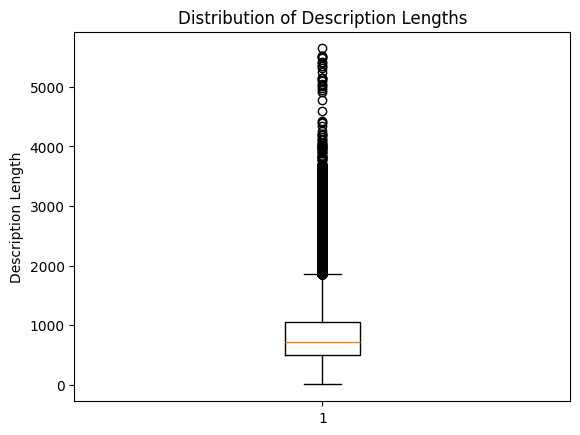

pd.describe() of all description lengths


count    124428.000000
mean        840.539051
std         464.254728
min           8.000000
25%         509.000000
50%         717.000000
75%        1049.000000
max        5641.000000
dtype: float64

In [18]:
# How long are the descriptions terms?

description_lengths = [len(x) for x in df_desc['product_description']]

# Create the boxplot
plt.figure()
plt.boxplot(description_lengths)
plt.ylabel('Description Length')
plt.title('Distribution of Description Lengths')
plt.show()

print("pd.describe() of all description lengths")
pd.Series(description_lengths).describe()

## `attributes.csv`

In [19]:
df_attr = pd.read_csv('raw_data/attributes.csv', encoding = 'ISO-8859-1')
print(df_attr.shape)
df_attr.tail(10)

(2044803, 3)


,product_uid,name,value
2044793,224428.0,Individual/Set,Individual
2044794,224428.0,Material Cut,Multi-Purpose
2044795,224428.0,MFG Brand Name,Bosch
2044796,224428.0,Min Chuck Size Required,3/8 In.
2044797,224428.0,Number of Pieces,1
2044798,224428.0,Pilot Bit Included,No
2044799,224428.0,Power Tool Product Type,Drill & Router Bits
2044800,224428.0,Shank Diameter,3/8 in
2044801,224428.0,Shank Style,Hex
2044802,224428.0,Tools Product Type,Power Tool


In [20]:
# How many products have attributes?

merged_df = df_desc.merge(df_attr, how='left', on='product_uid', indicator=True)
missing_uids = merged_df[merged_df['_merge'] == 'left_only']['product_uid']

no_attr_products = len(missing_uids.to_list())

print(f'There are {str(no_attr_products)} of the total {str(len(df_desc))} products without attributes')

There are 38165 of the total 124428 products without attributes


In [21]:
# How many attribute types are there?
len(df_attr['name'].unique())

5411

In [22]:
df_attr['name'].unique()

array(['Bullet01', 'Bullet02', 'Bullet03', ..., 'Grill light included',
       'Side Burner', 'Warming Rack'], dtype=object)

In [23]:
# How many attributes do products typically have?

pd.Series(df_attr.groupby('product_uid').size()).describe()

count    86263.000000
mean        23.702491
std          9.614134
min          5.000000
25%         17.000000
50%         22.000000
75%         29.000000
max         88.000000
dtype: float64

# Create Datasets

In [24]:
def convert_to_dict(string):
    try:
        return ast.literal_eval(string)
    except (SyntaxError, ValueError):
        return None  # Handle cases where the string is not a valid dictionary representation


In [25]:
def generate_id(text):
    hash_object = hashlib.sha256(text.encode('utf-8'))  # SHA-256 example
    hex_digest = hash_object.hexdigest()
    return hex_digest

## Products

In [27]:
# Products

filename = "processed_data/df_prods.csv"

if os.path.isfile(filename):
    df_prods = pd.read_csv(filename)
    df_prods['product_attributes'] = df_prods['product_attributes'].apply(convert_to_dict)

else:
    # Start with product ids and titles
    df_prods = df[['product_uid', 'product_title']].drop_duplicates().reset_index(drop=True)

    # Merge in descriptions
    df_prods = df_prods.merge(df_desc, how = 'left', on = 'product_uid')

    # Collect attributes
    attr_ids = []
    attr_dicts = []
    for id in df_attr['product_uid'].unique():
        attr_ids.append(id)
        attr_tmp = df_attr[df_attr['product_uid']==id]
        if len(attr_tmp)>0:
            attrs = {}
            for index, row in attr_tmp.iterrows():
                attrs[row['name']] = row['value']
            attr_dicts.append(attrs)
        else:
            attr_dicts.append(None)

    df_attributes = pd.DataFrame({'product_uid': attr_ids,
                                'product_attributes': attr_dicts})     

    # Merge in attributes
    df_prods = df_prods.merge(df_attributes, how = 'left', on = 'product_uid')

    df_prods.to_csv(filename, index=False)

df_prods.head()

,product_uid,product_title,product_description,product_attributes
0,100001,Simpson Strong-Tie 12-Gauge Angle,"Not only do angles make joints stronger, they ...",{'Bullet01': 'Versatile connector for various ...
1,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,BEHR Premium Textured DECKOVER is an innovativ...,"{'Application Method': 'Brush,Roller,Spray', '..."
2,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,Update your bathroom with the Delta Vero Singl...,"{'Bath Faucet Type': 'Combo Tub and Shower', '..."
3,100006,Whirlpool 1.9 cu. ft. Over the Range Convectio...,Achieving delicious results is almost effortle...,"{'Appliance Type': 'Over the Range Microwave',..."
4,100007,Lithonia Lighting Quantum 2-Light Black LED Em...,The Quantum Adjustable 2-Light LED Black Emerg...,"{'Battery Power Type': 'Ni-Cad', 'Battery Size..."


## Queries

In [29]:
# Queries

filename = "processed_data/df_queries.csv"

if os.path.isfile(filename):
    df_queries = pd.read_csv(filename)
else:
    df_queries = pd.DataFrame(df['search_term'].unique()).rename(columns={0: 'search_term'})
    df_queries['query_id'] = [generate_id(x) for x in df_queries['search_term']]
    df_queries['has_relevant_results'] = df_queries['search_term'].isin(df_train['search_term']).astype(int)

    df_queries.to_csv(filename, index=False)

df_queries.head()

,search_term,query_id,has_relevant_results
0,angle bracket,6e0a07626e48aee6f7ce9ec6cd753426d6acafded1598f...,1
1,l bracket,5863e75dfdc9ae5db3f6b4dbddf129d5568e085bf57711...,1
2,deck over,406b3569b2db043604fdb42a67f4ec49964a5ff07cddf0...,1
3,rain shower head,49b2dc56a0e1945c435c1579c07df519878619e3e8d59d...,1
4,shower only faucet,7620551bacb6cdddca5f33ec0943cea7971095a1e9be06...,1


## Query Relevance

In [31]:
# Join query_ids onto df_train

filename = "processed_data/df_relevance.csv"

if os.path.isfile(filename):
    df_relevance = pd.read_csv(filename)
else:
    df_relevance = df_train.merge(df_queries, how = 'left', on = 'search_term')
    df_relevance = df_relevance[['query_id', 'product_uid', 'relevance']]
    df_relevance.to_csv(filename, index=False)
df_relevance.head()

,query_id,product_uid,relevance
0,6e0a07626e48aee6f7ce9ec6cd753426d6acafded1598f...,100001,3.00
1,5863e75dfdc9ae5db3f6b4dbddf129d5568e085bf57711...,100001,2.50
2,406b3569b2db043604fdb42a67f4ec49964a5ff07cddf0...,100002,3.00
3,49b2dc56a0e1945c435c1579c07df519878619e3e8d59d...,100005,2.33
4,7620551bacb6cdddca5f33ec0943cea7971095a1e9be06...,100005,2.67
